In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_validate, learning_curve, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    make_scorer
)
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [12]:
# Load and prepare the dataset
try:
    students = pd.read_csv("../data/processed/train_cleaned.csv")
    X = students.iloc[:, :-1]
    y = students.iloc[:, -1]
except FileNotFoundError:
    print("Error: The file was not found.")
    exit()
except Exception as e:
    print(f"An error occurred: {e}")
    exit()
# Preprocess the data by scaling features and encoding labels
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [13]:
# K-Fold Cross-Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [14]:
# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}


In [15]:
# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0, pos_label=1),
    'recall': make_scorer(recall_score, zero_division=0, pos_label=1),
    'f1': make_scorer(f1_score, zero_division=0, pos_label=1),
    'roc_auc': 'roc_auc'
}

In [16]:
# Train and evaluate models using cross-validation
results = {}
for name, model in models.items():
    cv_results = cross_validate(
        estimator=model,
        X=X_scaled,
        y=y_encoded,
        cv=kf,
        scoring=scoring,
        return_train_score=True,
        return_estimator=True
    )
    results[name] = cv_results


In [17]:
## 6. Analisar resultados
print("\nResultados da Validação Cruzada:")
print(f"Acurácia Média: {np.mean(cv_results['test_accuracy']):.4f} (±{np.std(cv_results['test_accuracy']):.4f})")
print(f"Precisão Média: {np.mean(cv_results['test_precision']):.4f} (±{np.std(cv_results['test_precision']):.4f})")
print(f"Recall Médio: {np.mean(cv_results['test_recall']):.4f} (±{np.std(cv_results['test_recall']):.4f})")
print(f"F1-Score Médio: {np.mean(cv_results['test_f1']):.4f} (±{np.std(cv_results['test_f1']):.4f})")
print(f"ROC-AUC Médio: {np.mean(cv_results['test_roc_auc']):.4f} (±{np.std(cv_results['test_roc_auc']):.4f})")


Resultados da Validação Cruzada:
Acurácia Média: 0.7807 (±0.0271)
Precisão Média: 0.8323 (±0.0240)
Recall Médio: 0.7061 (±0.1030)
F1-Score Médio: 0.7586 (±0.0509)
ROC-AUC Médio: 0.7796 (±0.0281)


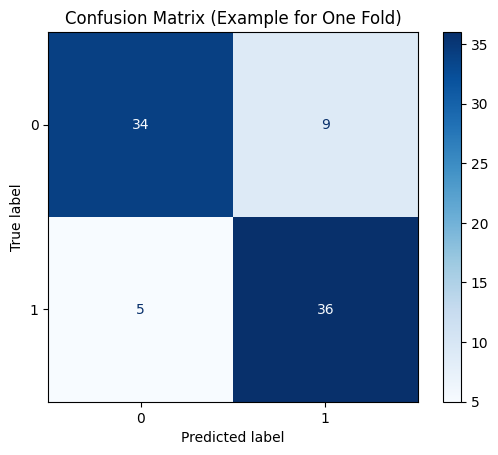

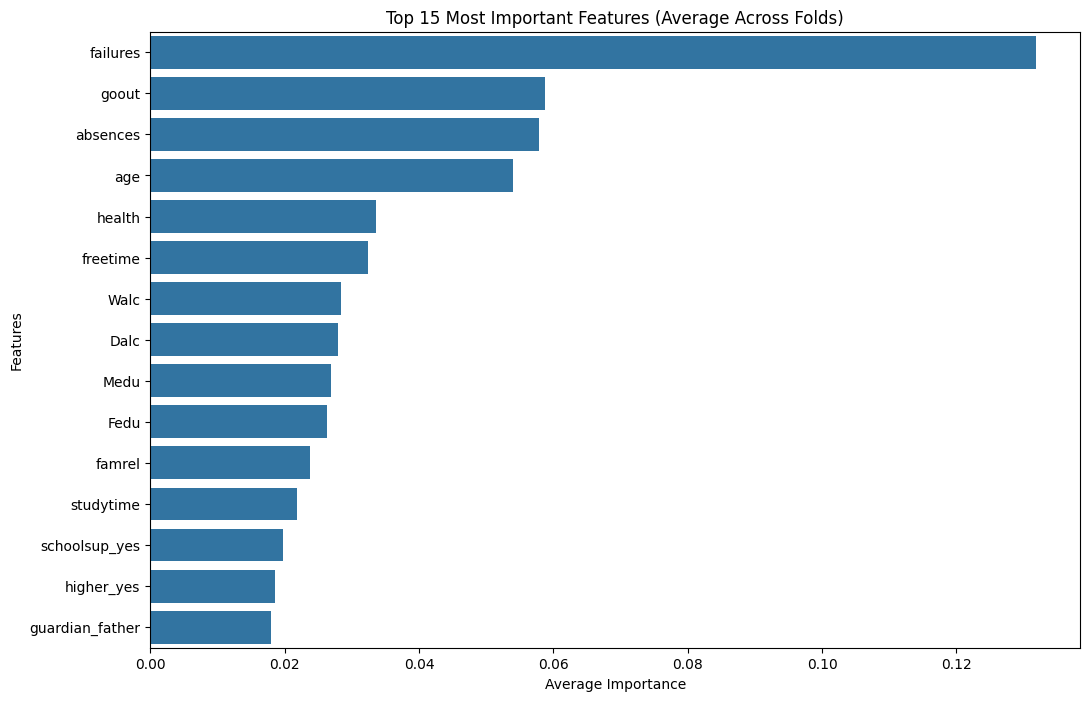

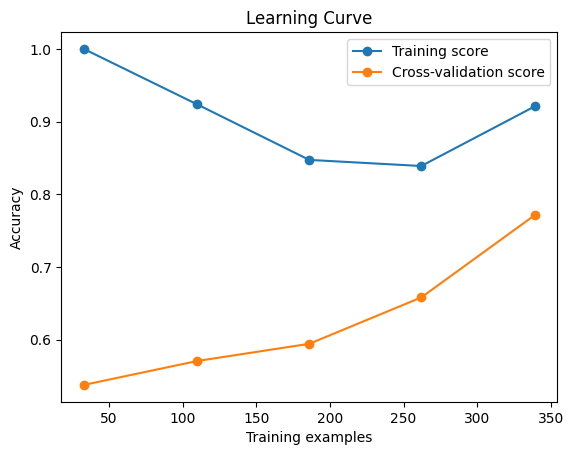


Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 200}
Best score for Random Forest: 0.8420448179271709

Model Comparison:
                             accuracy         precision            recall  \
Random Forest        0.7737 (±0.0485)  0.7560 (±0.0551)  0.8161 (±0.0348)   
Logistic Regression  0.7216 (±0.0282)  0.7247 (±0.0502)  0.7211 (±0.0383)   
KNN                  0.6061 (±0.0520)  0.6050 (±0.0576)  0.6115 (±0.0702)   
Decision Tree        0.7807 (±0.0271)  0.8323 (±0.0240)  0.7061 (±0.1030)   

                                   f1           roc_auc  
Random Forest        0.7839 (±0.0389)  0.8397 (±0.0340)  
Logistic Regression  0.7212 (±0.0284)  0.7603 (±0.0321)  
KNN                  0.6069 (±0.0592)  0.6486 (±0.0374)  
Decision Tree        0.7586 (±0.0509)  0.7796 (±0.0281)  


In [22]:
# Visualize the results for Random Forest
train_idx, test_idx = list(kf.split(X_scaled))[-1]
X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

rf_results = results["Random Forest"]
model = rf_results['estimator'][-1]
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Example for One Fold)')
plt.savefig("../docs/confusion_matrix.png")
plt.show()

if hasattr(model, 'feature_importances_'):
    feature_importances = np.mean([est.feature_importances_ for est in rf_results['estimator']], axis=0)
    features = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=features.head(15).values, y=features.head(15).index)
    plt.title('Top 15 Most Important Features (Average Across Folds)')
    plt.xlabel('Average Importance')
    plt.ylabel('Features')
    plt.savefig("../docs/feature_importances.png")
    plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    X_scaled, y_encoded, cv=kf, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)
plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation score")
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("../docs/learning_curve.png")
plt.show()

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_scaled, y_encoded)
print("\nBest parameters for Random Forest:", grid_search.best_params_)
print("Best score for Random Forest:", grid_search.best_score_)

# Compare the performance of different models
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
comparison = pd.DataFrame(index=results.keys(), columns=metrics)

for name, cv_results in results.items():
    for metric in metrics:
        comparison.loc[name, metric] = f"{np.mean(cv_results[f'test_{metric}']):.4f} (±{np.std(cv_results[f'test_{metric}']):.4f})"

print("\nModel Comparison:")
print(comparison)